# 7.2. Convoluções para Imagens

Com base em nossa motivação de redes neurais convolucionais como arquiteturas eficientes para explorar a estrutura em dados de imagem, ficamos com imagens como nosso exemplo em execução.

In [1]:
import torch
from torch import nn
from d2l import torch as d2l

# 7.2.1. A operação de correlação cruzada

Um tensor de entrada e um tensor de kernel são combinados para produzir um tensor de saída por meio de uma operação de correlação cruzada.

Vamos ignorar os canais por enquanto e ver como isso funciona com dados bidimensionais e representações ocultas.

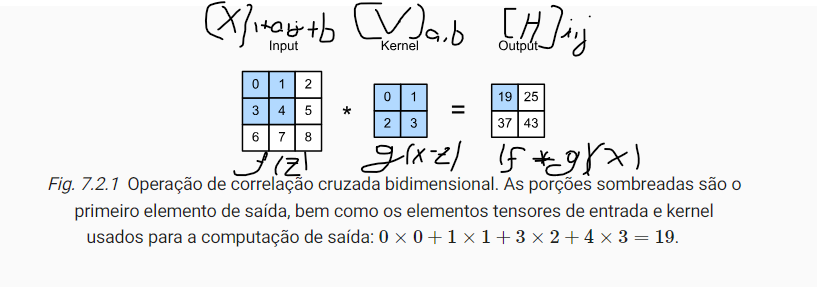

A saída algumas vezes é chamada de __mapa de características__.

O formato da janela do kernel (ou janela de convolução ) é dado pela altura e largura do kernel (aqui é 2x2).

- Na operação de correlação cruzada bidimensional, começamos com a janela de convolução posicionada no canto superior esquerdo do tensor de entrada e a deslizamos pelo tensor de entrada, tanto da esquerda para a direita quanto de cima para baixo.

-  Quando a janela de convolução desliza para uma determinada posição, o subtensor de entrada contido naquela janela e o tensor kernel são multiplicados elemento a elemento e o tensor resultante é somado, produzindo um único valor escalar. Este resultado fornece o valor do tensor de saída no local correspondente. Aqui, o tensor de saída tem uma altura de 2 e largura de 2 e os quatro elementos são derivados da operação de correlação cruzada bidimensional:

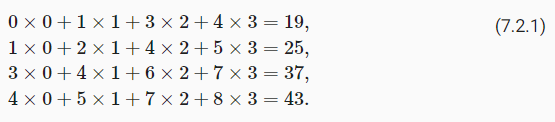

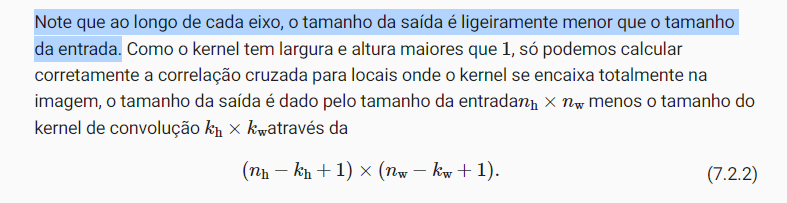

h: height, and \
w: width


In [2]:
def corr2d(X, K):                                                   # Realiza a CONVOLUÇÃO
    """Compute 2D cross-correlation."""
    h, w = K.shape
    Y = torch.zeros((X.shape[0] - h + 1, X.shape[1] - w + 1))
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            Y[i, j] = (X[i:i + h, j:j + w] * K).sum()
    return Y

In [3]:
X = torch.tensor([[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]])
K = torch.tensor([[0.0, 1.0], [2.0, 3.0]])
corr2d(X, K)

tensor([[19., 25.],
        [37., 43.]])

# 7.2.2. Camadas convolucionais

Uma camada convolucional faz a correlação cruzada da entrada e do kernel e adiciona um viés escalar para produzir uma saída. Os dois parâmetros de uma camada convolucional são o kernel e o viés escalar. Ao treinar modelos baseados em camadas convolucionais, normalmente inicializamos os kernels aleatoriamente, assim como faríamos com uma camada totalmente conectada

Agora estamos prontos para implementar uma camada convolucional bidimensional com base na função corr2d definida acima.

In [5]:
class Conv2D(nn.Module):                 # Conv2D do zero (from scratch)
    def __init__(self, kernel_size):
        super().__init__()
        self.weight = nn.Parameter(torch.rand(kernel_size))  # pesos/kernel.
        self.bias = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        return corr2d(x, self.weight) + self.bias            # Propagação para frente é o corr2d implementado anteriormente.

# 7.2.3. Detecção de Bordas de Objetos em Imagens

Vamos analisar por um momento uma aplicação simples de uma camada convolucional: detectar a borda de um objeto em uma imagem encontrando a localização da mudança de pixel.

Primeiro, construímos uma “imagem” de pixels. As quatro colunas do meio são pretas (0) e o resto são brancos (1).

In [10]:
X = torch.ones((6, 8))
X[:, 2:6] = 0
X

tensor([[1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.]])

- Quando realizamos a operação de correlação cruzada com a entrada, se os elementos adjacentes horizontalmente forem os mesmos, a saída será 0. Caso contrário, a saída será diferente de zero. Observe que esse kernel é um caso especial de um operador de diferença finita, ou seja, ele calcula a diferença entre os valores de pixels adjacentes horizontalmente.

- Em seguida, construímos um kernel K com altura 1 e largura 2.


In [12]:
K = torch.tensor([[1.0, -1.0]])
K

tensor([[ 1., -1.]])

Estamos prontos para executar a operação de correlação cruzada com argumentos X(nossa entrada) e K(nosso kernel). Como você pode ver, detectamos 1
para a borda do branco ao preto e -1 para a borda do preto para o branco. Todas as outras saídas assumem o valor 0.

In [13]:
Y = corr2d(X, K)
Y


tensor([[ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.]])

Aplicando o kernel à imagem transposta ele desaparece. O kernel K detecta apenas bordas verticais.

In [14]:
X.t()

tensor([[1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.]])

In [15]:
corr2d(X.t(), K)

tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])

# 7.2.4. Aprendendo um Kernel

Projetar um detector de bordas por diferenças finitas [1, -1] é legal se sabemos que é exatamente isso que estamos procurando. No entanto, ao olharmos para kernels maiores e considerarmos camadas sucessivas de convoluções, pode ser impossível especificar precisamente o que cada filtro deve fazer manualmente.

Agora vamos ver se podemos aprender o kernel que gerou Y de X olhando apenas para os pares de entrada-saída. 

- Primeiro construímos uma camada convolucional e inicializamos seu kernel como um tensor aleatório.
- Em seguida, em cada iteração, usaremos o erro quadrado para comparar Y com a saída da camada convolucional.
- Podemos então calcular o gradiente para atualizar o kernel.
- Para simplificar, a seguir usamos a classe interna para camadas convolucionais bidimensionais e ignoramos o bias.

In [27]:
# Construct a two-dimensional convolutional layer with 1 output channel and a
# kernel of shape (1, 2). For the sake of simplicity, we ignore the bias here
conv2d = nn.LazyConv2d(out_channels=1, kernel_size=(1, 2), bias=False)                     # lazy=preguiçoso (sem entradas)

# The two-dimensional convolutional layer uses four-dimensional input and
# output in the format of (example, channel, height, width), where the batch
# size (number of examples in the batch) and the number of channels are both 1
X = X.reshape((1, 1, 6, 8))
Y = Y.reshape((1, 1, 6, 7))
lr = 3e-2  # Learning rate

for i in range(10):
    Y_hat = conv2d(X)
    l = (Y_hat - Y) ** 2
    conv2d.zero_grad()
    l.sum().backward()
    # Update the kernel
    conv2d.weight.data[:] -= lr * conv2d.weight.grad
    if (i + 1) % 2 == 0:
        print(f'epoch {i + 1}, loss {l.sum():.3f}')

epoch 2, loss 17.362
epoch 4, loss 6.157
epoch 6, loss 2.362
epoch 8, loss 0.941
epoch 10, loss 0.381


Note que o erro caiu para um valor pequeno após 10 iterações. Agora, daremos uma olhada no tensor do kernel que aprendemos.

In [28]:
conv2d.weight.data.reshape((1, 2))

tensor([[ 0.9262, -1.0531]])

# Código Agrupado

In [29]:
# -------------------------------------------------------------------------------------
import torch
from torch import nn
from d2l import torch as d2l
# -------------------------------------------------------------------------------------

# -------------------------------------------------------------------------------------
def corr2d(X, K):  #@save
    """Compute 2D cross-correlation."""
    h, w = K.shape
    Y = torch.zeros((X.shape[0] - h + 1, X.shape[1] - w + 1))
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            Y[i, j] = (X[i:i + h, j:j + w] * K).sum()
    return Y
# -------------------------------------------------------------------------------------

# -------------------------------------------------------------------------------------
# X = torch.tensor([[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]])
# K = torch.tensor([[0.0, 1.0], [2.0, 3.0]])
# corr2d(X, K)

X = torch.ones((6, 8))
X[:, 2:6] = 0
K = torch.tensor([[1.0, -1.0]])
Y = corr2d(X, K)
# -------------------------------------------------------------------------------------

# -------------------------------------------------------------------------------------
# Construct a two-dimensional convolutional layer with 1 output channel and a
# kernel of shape (1, 2). For the sake of simplicity, we ignore the bias here
conv2d = nn.LazyConv2d(1, kernel_size=(1, 2), bias=False)

# The two-dimensional convolutional layer uses four-dimensional input and
# output in the format of (example, channel, height, width), where the batch
# size (number of examples in the batch) and the number of channels are both 1
X = X.reshape((1, 1, 6, 8))
Y = Y.reshape((1, 1, 6, 7))
lr = 3e-2  # Learning rate

for i in range(10):                # 10 épocas
    Y_hat = conv2d(X)              # convolução para obter o Y_hat (y de saída) 
   
    l = (Y_hat - Y) ** 2           # loss
    
    conv2d.zero_grad()             # gradiente                    
    l.sum().backward()             
    
    # Update the kernel
    conv2d.weight.data[:] -= lr * conv2d.weight.grad      # atualiza a matriz de pesos(W) ou kernel(V)
    
    # Usado apenas para dar print apenas das épocas pares:
    if (i + 1) % 2 == 0:
        print(f'epoch {i + 1}, loss {l.sum():.3f}')
# -------------------------------------------------------------------------------------

# -------------------------------------------------------------------------------------
conv2d.weight.data.reshape((1, 2))
# -------------------------------------------------------------------------------------


epoch 2, loss 6.142
epoch 4, loss 1.267
epoch 6, loss 0.309
epoch 8, loss 0.092
epoch 10, loss 0.032


tensor([[ 1.0053, -0.9711]])

# 7.2.5. Correlação cruzada e convolução

E se tais camadas executarem operações de convolução estritas conforme definido em (7.1.6) em vez de correlações cruzadas? Para obter a saída da operação de convolução estrita , precisamos apenas inverter o tensor kernel bidimensional horizontalmente e verticalmente e, então, executar a operação de correlação cruzada com o tensor de entrada.

Vale ressaltar que, como os kernels são aprendidos a partir de dados no aprendizado profundo, as saídas das camadas convolucionais permanecem inalteradas, independentemente de tais camadas executarem operações de convolução estritas ou operações de correlação cruzada.

Mantendo a terminologia padrão na literatura de aprendizado profundo, continuaremos a nos referir à operação de correlação cruzada como uma convolução, embora, estritamente falando, seja um pouco diferente. Além disso, usamos o termo elemento para nos referir a uma entrada (ou componente) de qualquer tensor que represente uma representação de camada ou um kernel de convolução.

# 7.2.6. Mapa de Características e Campo Receptivo

A saída da camada convolucional é algumas vezes chamada de __mapa de características__, pois pode ser considerada como as representações aprendidas (características) nas dimensões espaciais (por exemplo, largura e altura) para a camada subsequente. 

Em CNNs, para qualquer elemento x de alguma camada, seu __campo receptivo__ se refere a todos os elementos (de todas as camadas anteriores) que podem afetar o cálculo de x durante a propagação direta. Note que o campo receptivo pode ser maior que o tamanho real da entrada.

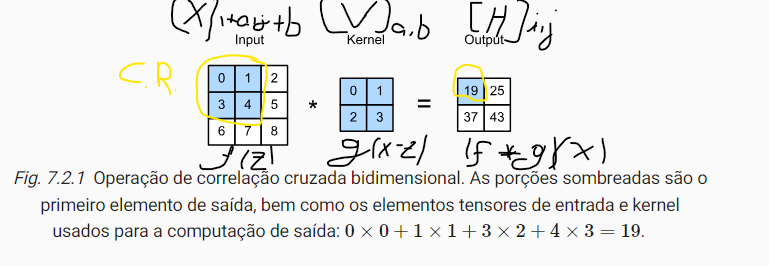

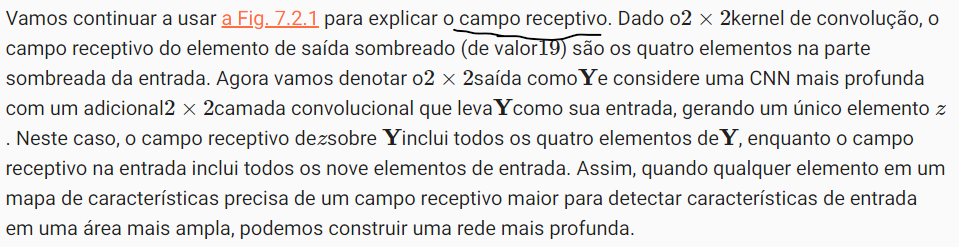

Basta dizer que as convoluções provaram ser uma ferramenta incrivelmente poderosa para a visão computacional, tanto em biologia quanto em código. Como tal, não é surpreendente (em retrospecto) que elas tenham anunciado o sucesso recente no aprendizado profundo.

# 7.2.7. Resumo

O cálculo central necessário para uma camada convolucional é uma operação de correlação cruzada (_cross-correlation operation_).

Como pode ser visto, o cálculo é direto e, mais importante, altamente local . Isso proporciona otimização significativa de hardware e muitos resultados recentes em visão computacional só são possíveis por causa disso. Afinal, isso significa que os projetistas de chips podem investir em computação rápida em vez de memória quando se trata de otimizar para convoluções. 

Em termos de convoluções em si, elas podem ser usadas para muitos propósitos, por exemplo, detectar bordas e linhas, desfocar imagens ou torná-las mais nítidas. Mais importante, não é necessário que o estatístico (ou engenheiro) invente filtros adequados. Em vez disso, podemos simplesmente aprendê -los a partir de dados.

Por fim, e muito agradável, esses filtros não são apenas vantajosos para construir redes profundas, mas também correspondem a campos receptivos e mapas de recursos no cérebro. Isso nos dá confiança de que estamos no caminho certo.

# 7.2.8. Exercícios

# Ex. 1 - Construa uma imagem X com bordas diagonais.



In [156]:
import torch
from torch import nn
from d2l import torch as d2l

X = torch.ones((6, 8))
l = X.shape[0]  # 6 
c = X.shape[1]  # 8
# -------------------
X[0,:] = 0
X[l-1,:] = 0
X[:,0] = 0
X[:,c-1] = 0
# -------------------
X[1,1] = 0
X[l-2,1] = 0
X[1,c-2] = 0
X[l-2,c-2] = 0
# -------------------
X

tensor([[0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 1., 1., 1., 0., 0.],
        [0., 1., 1., 1., 1., 1., 1., 0.],
        [0., 1., 1., 1., 1., 1., 1., 0.],
        [0., 0., 1., 1., 1., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.]])

# - O que acontece se você aplicar o kernel K desta seção a ele?

In [157]:
# detectamos 1 para a borda do branco ao preto e 
# -1 para a borda do preto para o branco. Todas as outras saídas assumem o valor 0.

K = torch.tensor([[1.0, -1.0]])
K

tensor([[ 1., -1.]])

In [158]:
def corr2d(X, K):                                                   # Realiza a CONVOLUÇÃO
    """Compute 2D cross-correlation."""
    h, w = K.shape
    Y = torch.zeros((X.shape[0] - h + 1, X.shape[1] - w + 1))
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            Y[i, j] = (X[i:i + h, j:j + w] * K).sum()
    return Y

In [159]:
corr2d(X, K)

tensor([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0., -1.,  0.,  0.,  0.,  1.,  0.],
        [-1.,  0.,  0.,  0.,  0.,  0.,  1.],
        [-1.,  0.,  0.,  0.,  0.,  0.,  1.],
        [ 0., -1.,  0.,  0.,  0.,  1.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.]])

------------------------------------------------------------------------------------

In [160]:
import numpy as np
import matplotlib.pyplot as plt

Z = torch.ones((6, 8))
# -------------------
Z[0,0] = 0
Z[2,0] = 0
Z[4,0] = 0

Z[0,2] = 0
Z[0,4] = 0
Z[0,6] = 0
Z



tensor([[0., 1., 0., 1., 0., 1., 0., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1.],
        [0., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1.],
        [0., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1.]])

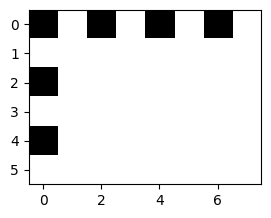

In [161]:
fig=plt.figure(figsize=(3, 4))
plt.imshow(Z, cmap=plt.cm.gray) 
# Preto: 0
# Branco: 1

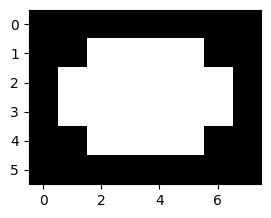

In [162]:
fig=plt.figure(figsize=(3, 4))
plt.imshow(X, cmap=plt.cm.gray) 
# Preto: 0
# Branco: 1

In [163]:
X

tensor([[0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 1., 1., 1., 0., 0.],
        [0., 1., 1., 1., 1., 1., 1., 0.],
        [0., 1., 1., 1., 1., 1., 1., 0.],
        [0., 0., 1., 1., 1., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.]])

In [164]:
C = corr2d(X, K)
C

tensor([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0., -1.,  0.,  0.,  0.,  1.,  0.],
        [-1.,  0.,  0.,  0.,  0.,  0.,  1.],
        [-1.,  0.,  0.,  0.,  0.,  0.,  1.],
        [ 0., -1.,  0.,  0.,  0.,  1.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.]])

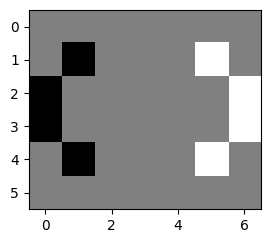

In [165]:
fig=plt.figure(figsize=(3, 4))
plt.imshow(C, cmap=plt.cm.gray) 
# Preto: -1
# Branco: 1
# Cinza: 0

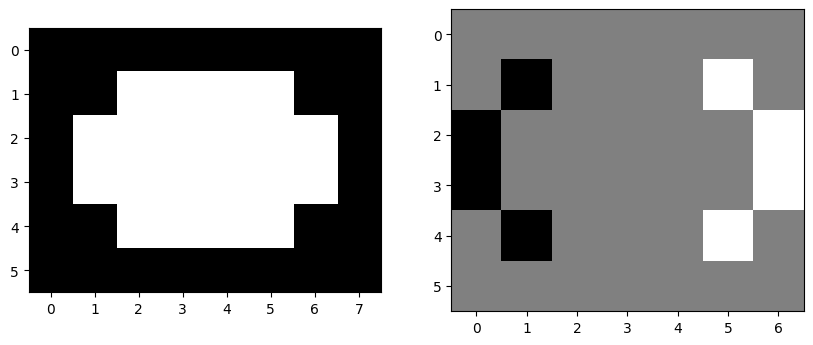

In [169]:
fig=plt.figure(figsize=(10, 6))

# fig=plt.figure(figsize=(6, 7))
fig.add_subplot(1, 2, 1)   # subplot one
plt.imshow(X, cmap=plt.cm.gray)

# fig=plt.figure(figsize=(6, 7))
fig.add_subplot(1, 2, 2)   # subplot two
plt.imshow(C, cmap=plt.cm.gray)

plt.show()

------------------------------------------------------------------

In [170]:
I = torch.eye(6)
I

tensor([[1., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 1.]])

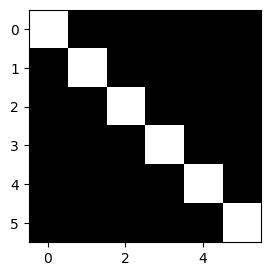

In [171]:
fig=plt.figure(figsize=(3,4))
plt.imshow(I, cmap=plt.cm.gray) 
# Preto: 0
# Branco: 1

In [172]:
C = corr2d(I, K)
C

tensor([[ 1.,  0.,  0.,  0.,  0.],
        [-1.,  1.,  0.,  0.,  0.],
        [ 0., -1.,  1.,  0.,  0.],
        [ 0.,  0., -1.,  1.,  0.],
        [ 0.,  0.,  0., -1.,  1.],
        [ 0.,  0.,  0.,  0., -1.]])

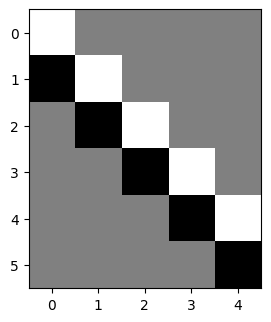

In [173]:
fig=plt.figure(figsize=(3, 4))
plt.imshow(C, cmap=plt.cm.gray) 
# Preto: -1
# Branco: 1
# Cinza: 0

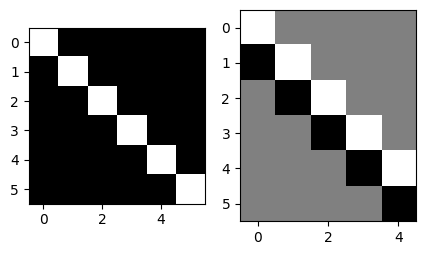

In [177]:
# fig=plt.figure(figsize=(10,6))
fig=plt.figure(figsize=(5,3))

# fig=plt.figure(figsize=(6, 7))
fig.add_subplot(1, 2, 1)   # subplot one
plt.imshow(I, cmap=plt.cm.gray)

# fig=plt.figure(figsize=(6, 7))
fig.add_subplot(1, 2, 2)   # subplot two
plt.imshow(C, cmap=plt.cm.gray)

plt.show()
# Preto: -1
# Branco: 1
# Cinza: 0

In [ ]:
# detectamos 1 (branco na imagem da direita) para a borda do branco ao preto e 
# -1 (preto na imagem da direita) para a borda do preto para o branco. Todas as outras saídas assumem o valor 0 (cinza).

# Ex. 2 - O que acontece se você transpor X?

In [183]:
X

tensor([[0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 1., 1., 1., 0., 0.],
        [0., 1., 1., 1., 1., 1., 1., 0.],
        [0., 1., 1., 1., 1., 1., 1., 0.],
        [0., 0., 1., 1., 1., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.]])

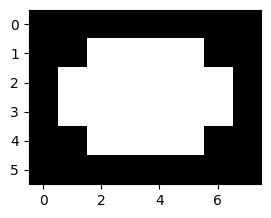

In [184]:
fig=plt.figure(figsize=(3, 4))
plt.imshow(X, cmap=plt.cm.gray) 
# Preto: 0
# Branco: 1

In [186]:
T = X.t()
T

tensor([[0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 1., 0., 0.],
        [0., 1., 1., 1., 1., 0.],
        [0., 1., 1., 1., 1., 0.],
        [0., 1., 1., 1., 1., 0.],
        [0., 1., 1., 1., 1., 0.],
        [0., 0., 1., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0.]])

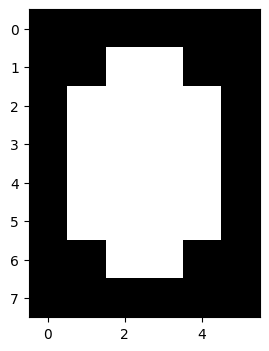

In [187]:
fig=plt.figure(figsize=(3, 4))
plt.imshow(T, cmap=plt.cm.gray) 
# Preto: 0
# Branco: 1

In [188]:
C = corr2d(T, K)
C

tensor([[ 0.,  0.,  0.,  0.,  0.],
        [ 0., -1.,  0.,  1.,  0.],
        [-1.,  0.,  0.,  0.,  1.],
        [-1.,  0.,  0.,  0.,  1.],
        [-1.,  0.,  0.,  0.,  1.],
        [-1.,  0.,  0.,  0.,  1.],
        [ 0., -1.,  0.,  1.,  0.],
        [ 0.,  0.,  0.,  0.,  0.]])

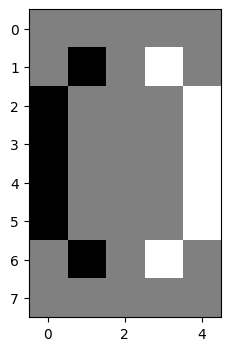

In [190]:
fig=plt.figure(figsize=(3, 4))
plt.imshow(C, cmap=plt.cm.gray) 
# Preto: -1
# Branco: 1
# Cinza: 0

# Ex. 3 - O que acontece se você transpor K?

In [192]:
C = corr2d(X, K)
C

tensor([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0., -1.,  0.,  0.,  0.,  1.,  0.],
        [-1.,  0.,  0.,  0.,  0.,  0.,  1.],
        [-1.,  0.,  0.,  0.,  0.,  0.,  1.],
        [ 0., -1.,  0.,  0.,  0.,  1.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.]])

In [193]:
C = corr2d(X, K.t())
C

tensor([[ 0.,  0., -1., -1., -1., -1.,  0.,  0.],
        [ 0., -1.,  0.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  1.,  0.,  0.,  0.,  0.,  1.,  0.],
        [ 0.,  0.,  1.,  1.,  1.,  1.,  0.,  0.]])

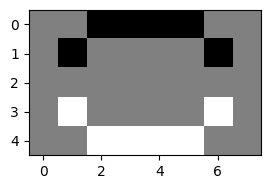

In [194]:
fig=plt.figure(figsize=(3, 4))
plt.imshow(C, cmap=plt.cm.gray) 
# Preto: -1
# Branco: 1
# Cinza: 0

# Ex. 2.3 - Como você projetaria um kernel de desfoque? Por que você pode querer usar tal kernel?

Será realizado utilizando distribuição normal/gaussiana randomica.

Text(0.5, 1.0, 'Kernel randomico (4,4) com distribuição normal:\n média=1 e desvio=0.05')

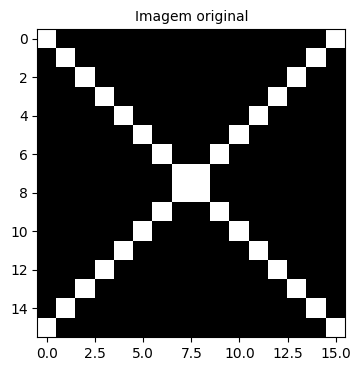

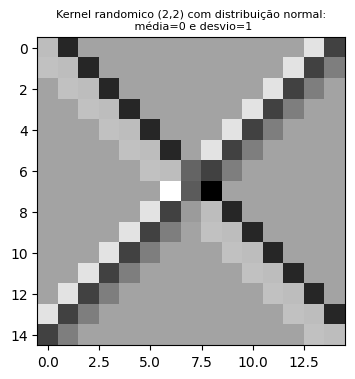

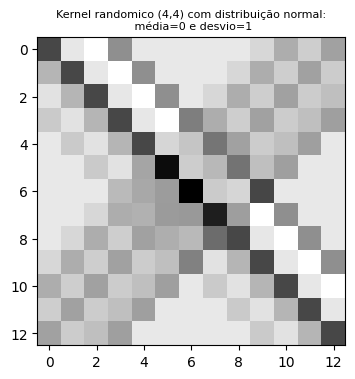

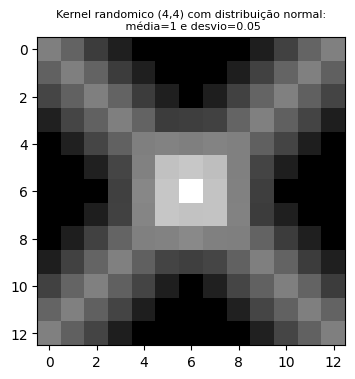

In [220]:
import torch
from torch import nn
from d2l import torch as d2l
import numpy as np
import matplotlib.pyplot as plt

# --------------------------------------------------------------------------------------------
def corr2d(X, K):                                                   # Realiza a CONVOLUÇÃO
    """Compute 2D cross-correlation."""
    h, w = K.shape
    Y = torch.zeros((X.shape[0] - h + 1, X.shape[1] - w + 1))
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            Y[i, j] = (X[i:i + h, j:j + w] * K).sum()
    return Y
# --------------------------------------------------------------------------------------------

# --------------------------------------------------------------------------------------------
# Cria a figura
# Make an array with ones in the shape of an 'X'
a = np.eye(16,16)   # cria a matriz identidade.
a += a[::-1,:]             # cria a matriz X.
x = torch.tensor(a)        # converte o ndarray para tensor

fig=plt.figure(figsize=(4, 4))
plt.imshow(x, cmap=plt.cm.gray)
plt.title('Imagem original', fontsize=10)
# --------------------------------------------------------------------------------------------

# --------------------------------------------------------------------------------------------
K0 = torch.randn(2,2)                    # Kernel randomico (2,2) com distribuição normal: média=0 e desvio=1
C = corr2d(x, K0)
fig=plt.figure(figsize=(4, 4))
plt.imshow(C, cmap=plt.cm.gray)
plt.title('Kernel randomico (2,2) com distribuição normal:\n média=0 e desvio=1', fontsize=8)

K1 = torch.randn(4,4)                    # Kernel randomico (4,4) com distribuição normal: média=0 e desvio=1
C = corr2d(x, K1)
fig=plt.figure(figsize=(4, 4))
plt.imshow(C, cmap=plt.cm.gray)
plt.title('Kernel randomico (4,4) com distribuição normal:\n média=0 e desvio=1', fontsize=8)

K2 = torch.normal(1, 0.05, size=(4,4))  # Kernel randomico (4,4) com distribuição normal: média=1 e desvio=0.05
C = corr2d(x, K2)
fig=plt.figure(figsize=(4, 4))
plt.imshow(C, cmap=plt.cm.gray)
plt.title('Kernel randomico (4,4) com distribuição normal:\n média=1 e desvio=0.05', fontsize=8)
# --------------------------------------------------------------------------------------------


# Ex. 3 - Quando você tenta encontrar automaticamente o gradiente para a Conv2D classe que criamos, que tipo de mensagem de erro você vê?

In [223]:
# -------------------------------------------------------------------------------------
import torch
from torch import nn
from d2l import torch as d2l
# -------------------------------------------------------------------------------------

# # -------------------------------------------------------------------------------------
# def corr2d(X, K):  #@save
#     """Compute 2D cross-correlation."""
#     h, w = K.shape
#     Y = torch.zeros((X.shape[0] - h + 1, X.shape[1] - w + 1))
#     for i in range(Y.shape[0]):
#         for j in range(Y.shape[1]):
#             Y[i, j] = (X[i:i + h, j:j + w] * K).sum()
#     return Y
# # -------------------------------------------------------------------------------------

# -------------------------------------------------------------------------------------
X = torch.ones((6, 8))
X[:, 2:6] = 0
# K = torch.tensor([[1.0, -1.0]])
# Y = corr2d(X, K)
# -------------------------------------------------------------------------------------


# -------------------------------------------------------------------------------------
class Conv2D(nn.Module):                 # Conv2D do zero (from scratch)
    def __init__(self, kernel_size):
        super().__init__()
        self.weight = nn.Parameter(torch.rand(kernel_size))  # pesos/kernel.
        self.bias = nn.Parameter(torch.zeros(1))

    def forward(self, X):
        return corr2d(X, self.weight)             # Propagação para frente é o corr2d implementado anteriormente.
# -------------------------------------------------------------------------------------

# -------------------------------------------------------------------------------------
# Create an instance of your custom Conv2D layer
ob_conv = Conv2D(kernel_size=(1, 2))                  # cria o objeto

# Set requires_grad to True
X.requires_grad = True

# Perform forward pass
output = ob_conv(X)                                   # introduz as entradas 

# Compute gradients
output.backward()
# -------------------------------------------------------------------------------------
# Access gradients
print("Gradient of weight:", ob_conv.weight.grad)
print("Gradient of bias:", ob_conv.bias.grad)
# -------------------------------------------------------------------------------------


RuntimeError: grad can be implicitly created only for scalar outputs

# Ex. 4 - Como você representa uma operação de correlação cruzada como uma multiplicação de matriz alterando os tensores de entrada e kernel?

E se tais camadas executarem operações de convolução estritas conforme definido em (7.1.6) em vez de correlações cruzadas? Para obter a saída da operação de convolução estrita, precisamos apenas inverter o tensor kernel bidimensional horizontalmente e verticalmente e, então, executar a operação de correlação cruzada com o tensor de entrada.

Vale ressaltar que, como os kernels são aprendidos a partir de dados no aprendizado profundo, as saídas das camadas convolucionais permanecem inalteradas, independentemente de tais camadas executarem operações de convolução estritas ou operações de correlação cruzada.

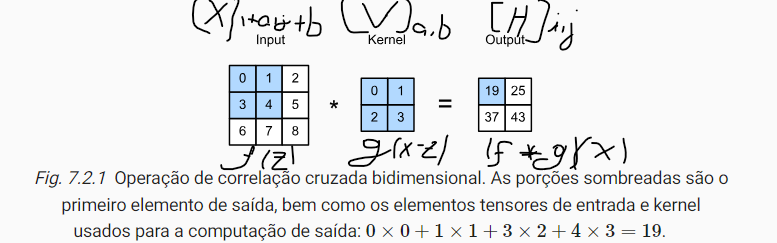

In [224]:
def corr2d(X, K):                                                   # Realiza a CONVOLUÇÃO
    """Compute 2D cross-correlation."""
    h, w = K.shape
    Y = torch.zeros((X.shape[0] - h + 1, X.shape[1] - w + 1))
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            Y[i, j] = (X[i:i + h, j:j + w] * K).sum()
    return Y

In [228]:
X = torch.tensor([[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]])
X

tensor([[0., 1., 2.],
        [3., 4., 5.],
        [6., 7., 8.]])

In [229]:
K = torch.tensor([[0.0, 1.0], [2.0, 3.0]])
K

tensor([[0., 1.],
        [2., 3.]])

In [230]:
C = corr2d(X, K)
C

tensor([[19., 25.],
        [37., 43.]])

----------------------------------

In [249]:
K1 = torch.tensor([[3.0,2.0],[1.0,0.0]])   #INVERSÃO HORIZONTAL E VERTICAL DE K
K1

tensor([[3., 2.],
        [1., 0.]])

In [261]:
C1 = corr2d(X, K1)
C1 

tensor([[ 5., 11.],
        [23., 29.]])

In [262]:
C1 + 14

tensor([[19., 25.],
        [37., 43.]])

O resultado bate apenas adicionando 14.

-------------------------------------------

In [264]:
torch.matmul(X[0:2,0:2],K1)

tensor([[ 1.,  0.],
        [13.,  6.]])

In [256]:
X[0:2,0:2]

tensor([[0., 1.],
        [3., 4.]])

In [265]:
K1


tensor([[3., 2.],
        [1., 0.]])

# Outras respostas:

https://pandalab.me/archives/convolutions_for_images